# The Timeseries Quantum Autoencoder (TS unary encoding)
*TS QAE in PennyLane with unary encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: October 2023<br>
Aims: The goal of this tutorial is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Individual TS values were encoded in their binary representation.
- Amplitude encoding of TS windows was used, but was padded with zeros (0) to ensure the total number of values to be $2^n$.
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
5. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
pip list | grep -E 'nvidia|PennyLane|torch'

nvidia-cublas-cu11            11.11.3.6
nvidia-cublas-cu12            12.1.3.1
nvidia-cuda-cupti-cu12        12.1.105
nvidia-cuda-nvrtc-cu12        12.1.105
nvidia-cuda-runtime-cu11      11.8.89
nvidia-cuda-runtime-cu12      12.1.105
nvidia-cudnn-cu12             8.9.2.26
nvidia-cufft-cu12             11.0.2.54
nvidia-curand-cu12            10.3.2.106
nvidia-cusolver-cu12          11.4.5.107
nvidia-cusparse-cu12          12.1.0.106
nvidia-nccl-cu12              2.18.1
nvidia-nvjitlink-cu12         12.2.140
nvidia-nvtx-cu12              12.1.105
PennyLane                     0.32.0
PennyLane-Lightning           0.32.0
PennyLane-Lightning-GPU       0.32.0
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/pennylane_qae',
 '/home/jacob/miniconda3/envs/pl/lib/python310.zip',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl/lib/python3.10/site-packages',
 '.',
 '..']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *

## Prepare windowed TS data
*Values need to be in [-100..+100] range*

### Prepare a time series

In [11]:
### Data settings
samples = 8*20
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 10
wind_step = 2
horizon = 1
scaler = 100
enc_digits = 12 # Includes 1 sign
test_level = 2 # 0 - no tests, 1 - primary tests, 2 - detailed tests

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
#y_all = f.fun(X_all)
y_all = [round(x*scaler, 0) for x in f.fun(X_all)]
X_all = [x for x in range(len(X_all))]

### Split data into windows
# Create windowed time series, ignore X units
# However, as the task is not predictive, so the horizon is ignored
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
    ts_wind_make(X_all, wind_size, wind_step), 
    ts_wind_make(y_all, wind_size, wind_step), 
    train_pc)

### Show TS parameters
if test_level >= 1:
    print(f'Selected Data\n')
    print(f'Function: {f.name}, Eps: {f.eps()}')
    print(f'Samples: {samples}, Split: {train_pc}, Train Samples: {samples_train}, Valid Samples: {samples_valid}')
    print(f'Window Size: {wind_size}, Step: {wind_step}, Horizon: {horizon}')
    print(f'Range: {(round(lb, 3), round(ub, 3))}')
    print(f'Training Range: {(round(lb_train, 3), round(ub_train, 3))}')
    print(f'Validation Range: {(round(lb_valid, 3), round(ub_valid, 3))}')
    print(f'T: {(round(ub-lb, 3))}')
    print()
    print(f'Training Windows: {X_train_ts.shape[0]}, Validation Windows: {X_valid_ts.shape[0]}')

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 160, Split: 0.7, Train Samples: 112, Valid Samples: 48
Window Size: 10, Step: 2, Horizon: 1
Range: (-6.283, 6.283)
Training Range: (-6.283, 2.513)
Validation Range: (2.513, 6.283)
T: 12.566

Training Windows: 109, Validation Windows: 47


### Plot data

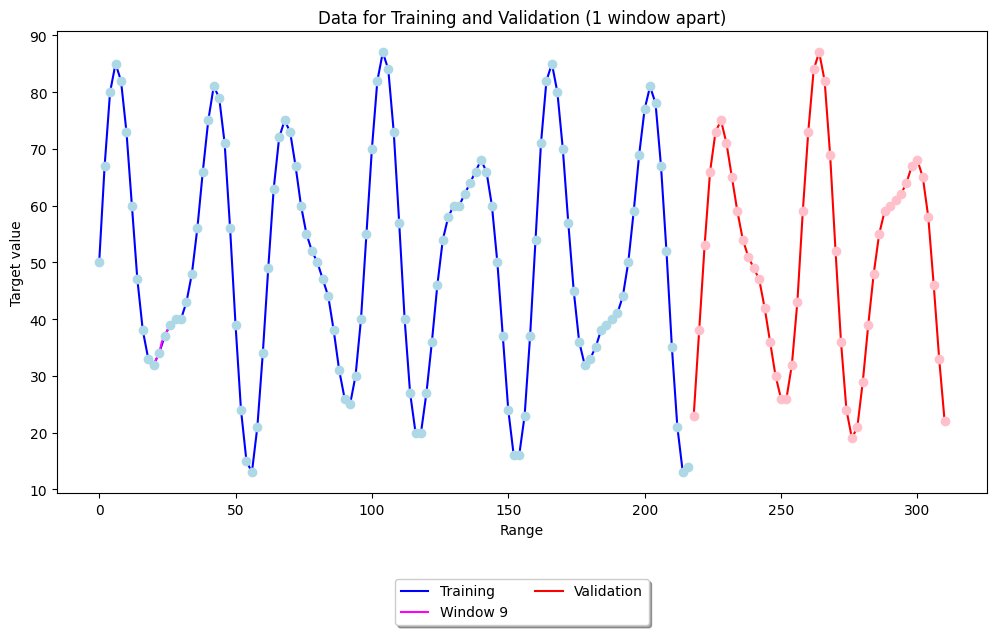



Sample Windows:

f([0,...,9]) ->
 [50.0, 59.0, 67.0, 74.0, 80.0, 83.0, 85.0, 85.0, 82.0, 78.0]
f([2,...,11]) ->
 [67.0, 74.0, 80.0, 83.0, 85.0, 85.0, 82.0, 78.0, 73.0, 67.0]
f([4,...,13]) ->
 [80.0, 83.0, 85.0, 85.0, 82.0, 78.0, 73.0, 67.0, 60.0, 54.0]
f([6,...,15]) ->
 [85.0, 85.0, 82.0, 78.0, 73.0, 67.0, 60.0, 54.0, 47.0, 42.0]
f([8,...,17]) ->
 [82.0, 78.0, 73.0, 67.0, 60.0, 54.0, 47.0, 42.0, 38.0, 35.0]



In [12]:
# Window to highlight
sel_wind = 9

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], color='blue', label='Training')
plt.plot(X_train_ts[sel_wind], y_train_ts[sel_wind], color='magenta', label='Window '+str(sel_wind))
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], color='red', label='Validation')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
# plt.plot(X_all, y_all, marker='o', color='lightblue', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

if test_level >= 1:
    print(f'\n\nSample Windows:\n')
    for i in range(5):
        print(f'f([{round(X_train_ts[i][0], 2)},...,{round(X_train_ts[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_ts[i]]}')
    print()

## Encoding TS windows
We can either quantize the TS values and rely on amplitude encoding (with RawFeatureVector),<br>
or we can use continuous TS values and utilize rotation encoding (with Z-Features or ZZ-Features).

Time series value quantization:
- The time series values will be mapped into a range of -100..+100
- Every value in the TS will be encoded relative to the previous value in terms of their difference
- The difference between values will be encoded into vn qubits, i.e. the sign and its bit representation
- The negative zero will be converted into an unsigned (positive) zero
- There are a few different ways of encoding the bit representation, e.g.
  
| Type | Example | No of Bits | Sign Location | Representation | Value Range |
| --- | :-: | :-: | :-: | --- | --- |
| Binary | -5 | 5 bits | bit 0 (right) | [0 1 0 1 1] | [-15, +15] |
| Unary | -5 | 8 bits | bit 0 (right) | [0 0 1 0 0 0 0 1] | [-7, +7] |


### Unary encoding

In [13]:
### Unary encoding of a TS value relative to the previous value
#   prev_raw: Previous value
#   next_raw: Next value
#   optional digits=8: Number of digits in representations, including sign
#   optional scaler=1: Number scaler 
#   returns: Encoding of the next value relative to the previous value in [-digits..+digits] range
#   error: when abs(next-prev) > digits, an error value is returned
def ts_reluna_encode_val(prev_raw, next_raw, digits=16, scaler=1):
    digits = digits-1 # Sign will be added later
    prev = int(round(prev_raw * scaler, 0))
    next = int(round(next_raw * scaler, 0))
    val = next-prev
    sign = 1 if val < 0 else 0
    val = np.abs(val)
    res = [0]*digits
    # print(f'res={res}, sign={sign}, digits={digits}, val={val}')
    
    if val > digits:
        print('*** Value out of range')
        res[digits-1] = 1
    elif val != 0:
        res[val-1] = 1
    return [sign]+res

### Decoding
def ts_reluna_decode_val(prev_raw, next_code, scaler=1):
    next_incr = 0
    sign = -1 if next_code[0] > 0.5 else 1
    for pos in range(len(next_code) - 1):
        next_incr += (pos+1)*next_code[pos+1]
    return prev_raw + sign*(next_incr / scaler)

### Normalises the value to 1 (esp. when fuzzy)
def ts_reluna_norm_val(next_code):
    norm_code = next_code
    sign = 1 if next_code[0] > 0.5 else 0
    val_total = np.sum(next_code[1:])
    if val_total != 0:
        for pos in range(len(next_code) - 1):
            norm_code[pos+1] = next_code[pos+1]/val_total
        norm_code[0] = sign
    return norm_code

### Print encoding and decoding for testing
def print_ts_reluna_encode_val(p, n, digits=16):
    print(f'{(p, n)} -> {ts_reluna_encode_val(p, n, digits=digits)}')
    
def print_ts_reluna_decode_val(p, n):
    print(f'{(p, n)} -> {ts_reluna_decode_val(p, n)}')

def print_ts_reluna_norm_val(p):
    p_org = [np.round(ip, 2) for ip in p]
    p_norm = [np.round(ip, 2) for ip in ts_reluna_norm_val(p)]
    print(f'{(p_org)} -> {p_norm}')


### Tests
if test_level >= 1:
    print('Encoding:')
    print_ts_reluna_encode_val(30, 30, digits=8)
    print_ts_reluna_encode_val(30, 35, digits=8)
    print_ts_reluna_encode_val(35, 30, digits=8)
    print_ts_reluna_encode_val(30, 50, digits=8) # Incorrect
    print_ts_reluna_encode_val(50, 30, digits=8) # Incorrect
    
    print('\nDecoding:')
    print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 0, 0, 0])
    print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 1, 0, 0])
    print_ts_reluna_decode_val(35, [1, 0, 0, 0, 0, 1, 0, 0])
    print_ts_reluna_decode_val(30, [0, 0, 0, 0, 0, 0, 0, 1]) # Incorrect
    print_ts_reluna_decode_val(50, [1, 0, 0, 0, 0, 0, 0, 1]) # Incorrect
    
    print('\nFuzzy Decoding:')
    print_ts_reluna_decode_val(30, [0, 0, 0, 0.5, 0, 0.5, 0, 0]) # 1.5 + 2.5
    print_ts_reluna_decode_val(35, [0.6, 0, 0, 0.5, 0, 0.5, 0, 0]) # -(1.5 + 2.5)
    print_ts_reluna_decode_val(30, [0.2, 0.2, 0.2, 0, 0.2, 0.2, 0, 0.2])
    
    print('\nNormalise Encoding:')
    print_ts_reluna_norm_val([0, 0, 0, 0, 0, 0, 0, 0])
    print_ts_reluna_norm_val([0, 0, 0, 0.5, 0, 0.5, 0.3, 0.1])
    print_ts_reluna_norm_val([0.6, 0, 0, 0.5, 0, 0.5, 0, 0])
    print_ts_reluna_norm_val([0.2, 0.2, 0.2, 0, 0.2, 0.2, 0.2, 0.2])

Encoding:
(30, 30) -> [0, 0, 0, 0, 0, 0, 0, 0]
(30, 35) -> [0, 0, 0, 0, 0, 1, 0, 0]
(35, 30) -> [1, 0, 0, 0, 0, 1, 0, 0]
*** Value out of range
(30, 50) -> [0, 0, 0, 0, 0, 0, 0, 1]
*** Value out of range
(50, 30) -> [1, 0, 0, 0, 0, 0, 0, 1]

Decoding:
(30, [0, 0, 0, 0, 0, 0, 0, 0]) -> 30.0
(30, [0, 0, 0, 0, 0, 1, 0, 0]) -> 35.0
(35, [1, 0, 0, 0, 0, 1, 0, 0]) -> 30.0
(30, [0, 0, 0, 0, 0, 0, 0, 1]) -> 37.0
(50, [1, 0, 0, 0, 0, 0, 0, 1]) -> 43.0

Fuzzy Decoding:
(30, [0, 0, 0, 0.5, 0, 0.5, 0, 0]) -> 34.0
(35, [0.6, 0, 0, 0.5, 0, 0.5, 0, 0]) -> 31.0
(30, [0.2, 0.2, 0.2, 0, 0.2, 0.2, 0, 0.2]) -> 33.8

Normalise Encoding:
[0, 0, 0, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.5, 0, 0.5, 0.3, 0.1] -> [0, 0.0, 0.0, 0.36, 0.0, 0.36, 0.21, 0.07]
[0.6, 0, 0, 0.5, 0, 0.5, 0, 0] -> [1, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0]
[0.2, 0.2, 0.2, 0, 0.2, 0.2, 0.2, 0.2] -> [0, 0.17, 0.17, 0.0, 0.17, 0.17, 0.17, 0.17]


In [8]:
### Encoding the entire data set
def ts_reluna_encode(wind_set, digits=16, scaler=1):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        prev = wind[0]
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_reluna_encode_val(prev, val, digits, scaler)
            encoded_wind.append(encoded_val)
            prev = val
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_reluna_decode(org_wind_start, encoded_wind_set, scaler=1):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        prev = org_wind_start[wind_idx]
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_reluna_decode_val(prev, encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### Normalise the entire data set
def ts_reluna_norm(encoded_wind_set):
    norm_wind_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        norm_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            norm_val = ts_reluna_norm_val(encoded_val)
            norm_wind.append(norm_val)
        norm_wind_set.append(norm_wind)
    return np.array(norm_wind_set)

### Converting encoded windows into a list of circuit parameters by padding them to fit amplitude encoding
def ts_reluna_wind2params(enc_set, padding):
    wind_bits = enc_set[0].shape[0] * enc_set[0].shape[1]
    ts_params = [list(np.reshape(enc_wind, (wind_bits, ))) + [0]*padding for enc_wind in enc_set]
    return np.array(ts_params)

### Converting list of circuit parameters to encoded windows by removing padding
def ts_reluna_params2wind(params, padding):
    flat_windows = list([param[:-padding] for param in params])
    return np.reshape(flat_windows, (len(params), wind_size, enc_digits))

### Preparing data for training

In [14]:
y_train_enc, org_train_start = ts_reluna_encode(y_train_ts, digits=enc_digits)

### Optional tests
if test_level >= 2:
    y_train_dec = ts_reluna_decode(org_train_start, ts_reluna_norm(y_train_enc))
    print('Training windows before encoding:\n', y_train_ts[5:8])
    print('\nTraining windows after encoding:\n', y_train_enc[5:8])
    print('\nTraining windows org start:\n', org_train_start[5:8])
    print('\nTraining windows after decoding:\n', y_train_dec[5:8])

Training windows before encoding:
 [[73. 67. 60. 54. 47. 42. 38. 35. 33. 32.]
 [60. 54. 47. 42. 38. 35. 33. 32. 32. 33.]
 [47. 42. 38. 35. 33. 32. 32. 33. 34. 36.]]

Training windows after encoding:
 [[[0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 1 0 0 0 0]
  [1 0 0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 1 0 0 0 0]
  [1 0 0 0 0 1 0 0 0 0 0 0]
  [1 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 1 0 0 0 0 0 0 0 0]
  [1 0 1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 1 0 0 0 0]
  [1 0 0 0 0 1 0 0 0 0 0 0]
  [1 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 1 0 0 0 0 0 0 0 0]
  [1 0 1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 1 0 0 0 0 0 0]
  [1 0 0 0 1 0 0 0 0 0 0 0]
  [1 0 0 1 0 0 0 0 0 0 0 0]
  [1 0 1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0

In [16]:
wind_bits = wind_size * enc_digits
wind_qubits = int(np.ceil(np.log2(wind_bits)))
wind_padding = 2**wind_qubits - wind_bits

if test_level >= 1:
    print(f'Trainig TS windows properties\n')
    print(f'Each TS window has {wind_size} values, e.g. y_train_ts[6]={[int(x) for x in y_train_ts[6]]}')
    print(f'Each signed TS value is encoded as {enc_digits} bits, e.g. y_train_ts[6][9]={int(y_train_ts[6][9])}-{int(y_train_ts[6][8])}={y_train_enc[6][9]}')
    print(f'Each TS window has {wind_bits} bits, e.g. y_train_enc[6]:\n{y_train_enc[6]}')
    print(f'Each TS window requires {wind_qubits} qubits to encode with amplitude encoding')
    print(f'Each TS window parameters require window padding with extra {wind_padding} bits')

### Optional tests
if test_level >= 2:
    print(f'Example of parameter padding for y_train_ts[6] ->')
    print(f' {list(np.reshape(y_train_enc[6], (wind_bits, )))} + {[0]*wind_padding} =')
    print(f' {list(ts_reluna_wind2params(y_train_enc[6:7], wind_padding)[0])}')
    print(f'\nSample of padded window parameters y_train_enc[5:8]:')
    params_sample = ts_reluna_wind2params(y_train_enc[5:8], wind_padding)
    for param in params_sample:
        print(f' {list(param)}')

Trainig TS windows properties

Each TS window has 10 values, e.g. y_train_ts[6]=[60, 54, 47, 42, 38, 35, 33, 32, 32, 33]
Each signed TS value is encoded as 12 bits, e.g. y_train_ts[6][9]=33-32=[0 1 0 0 0 0 0 0 0 0 0 0]
Each TS window has 120 bits, e.g. y_train_enc[6]:
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]]
Each TS window requires 7 qubits to encode with amplitude encoding
Each TS window parameters require window padding with extra 8 bits
Example of parameter padding for y_train_ts[6] ->
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

## Amplitude encoding

First, we implement IBM's Qiskit to build our Quantum Autoencoder. We first begin by importing in the necessary libraries and fixing the seed.

In [19]:
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [11]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

In [17]:
num_qtrash = 2
num_qlatent = wind_qubits-num_qtrash
num_qdata = num_qlatent + num_qtrash
num_qdata_space = 2 ** (num_qdata)

if test_level >= 1:
    print(f'Qubit allocation: window = {wind_qubits}, trash = {num_qtrash},'+
          f'latent = {num_qlatent}, data = {num_qdata} for all data of {num_qdata_space}')

Qubit allocation: window = 7, trash = 2,latent = 5, data = 7 for all data of 128


### Building a data encoder
After encoding our TS windows into $(n+k)$ qubits, we begin to train our Quantum Autoencoder to compress this state into $k$ qubits.<br>
We will write a cost function based on the Swap Test between the trash and latent space.<br>
Note that the input state and trash space contain the same amount of qubits. 

Let's input one of our windows and see our circuit for the Autoencoder below. 

In [18]:
reps=4
ent='sca' # linear, reverse_linear, full, circular, sca
fm = RawFeatureVector(num_qdata_space)
wind_train_params = ts_reluna_wind2params(y_train_enc, wind_padding)

qc = QuantumCircuit(num_qdata)
qc = qc.compose(fm, range(num_qdata))

if test_level >= 1:
    display(qc.draw("mpl", scale=0.7))
    print('#Inputs:', len(fm.parameters), wind_train_params.shape)
    print()

NameError: name 'RawFeatureVector' is not defined

Again, we can see the swap test being performed on the selected qubits to determine the value of our cost function.

## Building amplitudes

In [14]:
!conda env list

# conda environments:
#
base                     /home/jacob/miniconda3
qiskit                   /home/jacob/miniconda3/envs/qiskit
qiskit-gpu            *  /home/jacob/miniconda3/envs/qiskit-gpu



In [15]:
from qiskit.visualization import plot_histogram
from qiskit import transpile, execute
from qiskit.circuit.library import QuantumVolume
from qiskit.providers.aer import AerSimulator, QasmSimulator
import sys

# sim = QasmSimulator()
sim = AerSimulator(method='statevector')
# sim = AerSimulator(method='tensor_network', device='GPU')
# sim = AerSimulator(method='statevector', device='GPU', cuStateVec_enable=True)

seed = 2023
shots = 500

def amp_qc_counts(qc, param_vals):
    qc_copy = qc
    bound_qc = qc_copy.bind_parameters(param_vals)    
    compiled_qc = transpile(bound_qc, sim)
    compiled_qc.measure_all()
    
    job = sim.run(compiled_qc, shots=shots) #, seed_simulator=seed)
    result = job.result()
    counts = result.get_counts(compiled_qc)
    return counts

Test 1 - Data for sample 5 (with filler):

    0 = [0 0 0 0 0 0 0 0 0 0 0 0]
   12 = [1 0 0 0 0 0 1 0 0 0 0 0]
   24 = [1 0 0 0 0 0 0 1 0 0 0 0]
   36 = [1 0 0 0 0 0 1 0 0 0 0 0]
   48 = [1 0 0 0 0 0 0 1 0 0 0 0]
   60 = [1 0 0 0 0 1 0 0 0 0 0 0]
   72 = [1 0 0 0 1 0 0 0 0 0 0 0]
   84 = [1 0 0 1 0 0 0 0 0 0 0 0]
   96 = [1 0 1 0 0 0 0 0 0 0 0 0]
  108 = [1 1 0 0 0 0 0 0 0 0 0 0]
  120 = [0 0 0 0 0 0 0 0]

Counts:

{'1100010': 21, '0101010': 23, '0100100': 25, '1100000': 31, '1010111': 28, '0010010': 30, '0110000': 20, '1000001': 31, '1001100': 29, '1101100': 19, '1101101': 40, '1001000': 29, '0011000': 31, '0011111': 22, '0001100': 31, '1010100': 28, '0111100': 26, '0110111': 36}



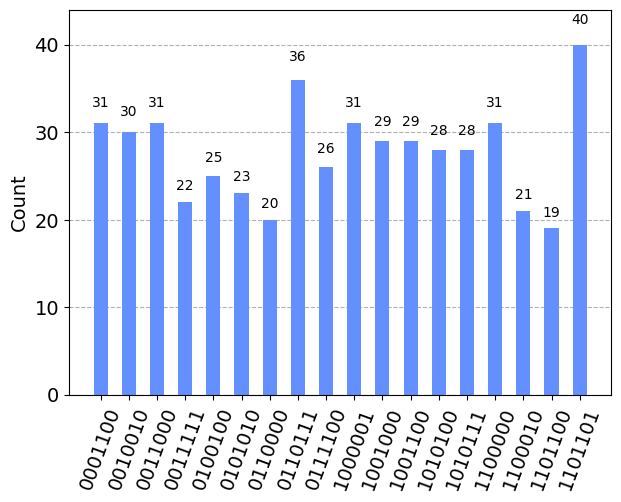


Test 2 - Artificial data (with filler):

    0 = [1 1 1 1 1 1 1 1 1 1 1 1]
   12 = [1 1 1 1 1 1 1 1 0 0 0 0]
   24 = [0 0 0 0 0 0 0 0 0 0 0 0]
   36 = [0 0 0 0 0 0 0 0 0 0 0 0]
   48 = [0 0 0 0 0 0 0 0 0 0 0 0]
   60 = [0 0 0 0 0 0 0 0 0 0 0 0]
   72 = [0 0 0 0 0 0 0 0 0 0 0 0]
   84 = [0 0 0 0 0 0 0 0 0 0 0 0]
   96 = [0 0 0 0 0 0 0 0 0 0 0 0]
  108 = [0 0 0 0 0 0 0 0 0 0 0 0]
  120 = [0 0 0 0 0 0 0 0]

Counts:

{'0000000': 26, '0000100': 19, '0000010': 19, '0001101': 19, '0010000': 19, '0001100': 22, '0001110': 18, '0010011': 27, '0001111': 20, '0000101': 36, '0010001': 26, '0001001': 25, '0001011': 35, '0000111': 27, '0000011': 25, '0001000': 32, '0000110': 27, '0000001': 30, '0010010': 24, '0001010': 24}



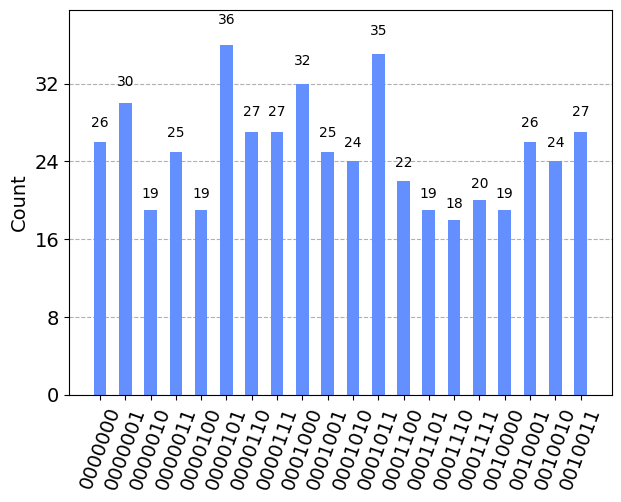



For our data of 0s and 1s, this encoding is identical to binary encoding


In [16]:
### Sample of real data
sel_train = 5
pv = wind_train_params[sel_train]
print(f'Test 1 - Data for sample {sel_train} (with filler):\n')
for i in range(0, len(pv), enc_digits): print(f'{i:>5} = {pv[i:i + enc_digits]}')
counts = amp_qc_counts(qc, pv)
print(f'\nCounts:\n\n{counts}\n')
display(plot_histogram(counts))

### Artificial data
n = 20
pv = np.array([1]*n+[0]*(len(wind_train_params[0])-n))
print('\nTest 2 - Artificial data (with filler):\n')
for i in range(0, len(pv), enc_digits): print(f'{i:>5} = {pv[i:i + enc_digits]}')
counts = amp_qc_counts(qc, pv)
print(f'\nCounts:\n\n{counts}\n')
display(plot_histogram(counts))
print(f'\n\nFor our data of 0s and 1s, this encoding is identical to binary encoding')

## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - **Issue 01** *Not sure how to interpret the output - cannot be visual*
          - **Issue 02** *Visual match between input and output not close*
          - **Issue 03** *Noise needs to be injected in training*
          - **Issue 04** *Training is getting slow, need to use GPU*
          - **Issue 05** *It is worth testing if an increase of the latent layer could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2: Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.

In [17]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright